First we will import the necessary libraries for this project and some utility functions I wrote for transforming the color space of images.

In [1]:
from utility_functions import convert_to_grayscale
import cv2
import numpy as np
from matplotlib import pyplot as plt

Part 1:
Before we use the canny edge detector, we will do some pre-processing.

Converting lab image to grayscale...


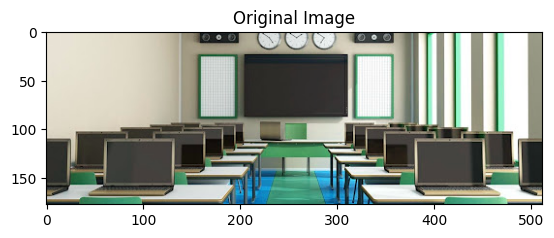

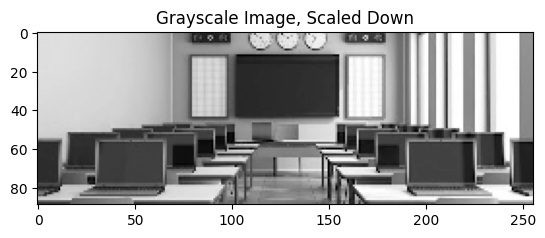

In [2]:
# read in the computer room image
lab_image = cv2.imread("Computer Room.jpg")

# resize the input image to speed up processing
y_size = int(lab_image.shape[0] / 2)
x_size = int(lab_image.shape[1] / 2)
lab_image_scaled = cv2.resize(lab_image, (x_size, y_size), interpolation=cv2.INTER_NEAREST)

# convert the lab image to grayscale
print("Converting lab image to grayscale...")
lab_image_grayscale = convert_to_grayscale(lab_image_scaled)

plt.imshow(lab_image)
plt.title('Original Image')
plt.figure()
plt.title('Grayscale Image, Scaled Down')
plt.imshow(lab_image_grayscale, cmap="gray")

Now for the Edge detection part.
We will apply our own Gaussian blur + cv2.canny to get a good amount of
edges (rather than just leaving the blur to the canny edge detector)

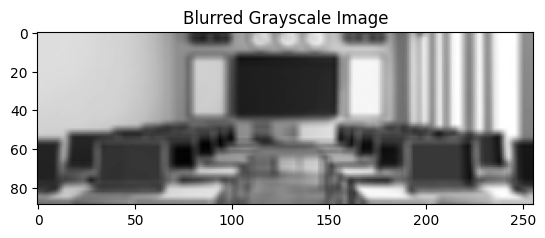

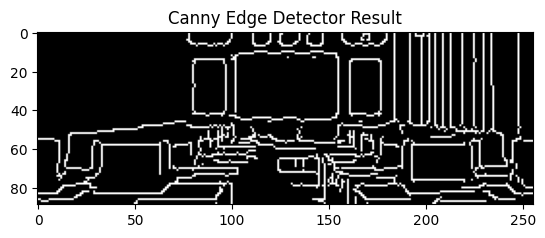

In [3]:
# 5x5 kernel for a flexible sigmaX blur cap
lab_blurred = cv2.GaussianBlur(lab_image_grayscale, (5, 5), sigmaX=2)
plt.title('Blurred Grayscale Image')
plt.imshow(lab_blurred, cmap="gray")

# Canny edge detector
edges_array = cv2.Canny(lab_blurred, threshold1=50, threshold2=150)

plt.figure()
plt.title('Canny Edge Detector Result')
plt.imshow(edges_array, cmap="gray")

Part 2:
The HoughLinesP function will return a 3d array of lines. Technically it acts more like a 2d array but its 3d for some reason (shape is (N, 1, 4)). Each line entry has a pair of coordinate values representing each line it found.
[x1, y1, x2, y2]

circles simply have a center, and a defined radius. HoughCircles will also return a weird shape (N, 1, 3).
[x, y, r]

Note that these are not complete shapes like squares or triangles. We would need to do extra steps to separate the image into shape definitions. This would be challenging to do with just Hough transform.

In [4]:
# use the Hough Transform to detect all lines/circles in the edge array
lines = cv2.HoughLinesP(edges_array, 1, np.pi / 180, threshold=50, minLineLength=20, maxLineGap=5)
circles = cv2.HoughCircles(edges_array, cv2.HOUGH_GRADIENT, dp=1, minDist=20, param1=100, param2=30, minRadius=5, maxRadius=50)

# print out the shape arrays requested by part 2
print("Line Array")
print(lines)
print("Circle Array")
print(circles)

Line Array
[[[ 52  86  92  86]]

 [[ 29  58  93  58]]

 [[144  73 184  75]]

 [[189  57 228  59]]

 [[192  32 234  27]]

 [[145  70 193  70]]

 [[ 22  83  64  83]]

 [[123  56 156  57]]

 [[124  66 150  64]]

 [[160  86 192  86]]

 [[ 63  70  87  70]]

 [[ 17  52  54  49]]

 [[208  82 233  82]]

 [[125  72 157  72]]

 [[145  78 189  79]]

 [[205  54 235  50]]

 [[ 81  41 102  43]]

 [[248  55 248   0]]

 [[ 88  51 129  60]]

 [[ 79  63 107  63]]

 [[234   0 234  26]]

 [[192  41 235  38]]

 [[ 68  78 100  78]]

 [[ 79  49 101  48]]

 [[192  47 218  48]]

 [[230  50 230   0]]

 [[184  46 184   0]]]
Circle Array
[[[162.5  25.5  49.4]
  [130.5  39.5  33.8]
  [183.5  31.5  29.3]
  [212.5  35.5  21.7]
  [128.5  18.5  33.8]
  [210.5  62.5  15. ]
  [201.5  17.5  10.3]]]


Part 3:
We will now be moving on from detecting basic shapes and use an algorithm to directly match an existing template object. That algorithm is SIFT.

some shorthand:
kp = keypoints
d = descriptors

BF matcher done


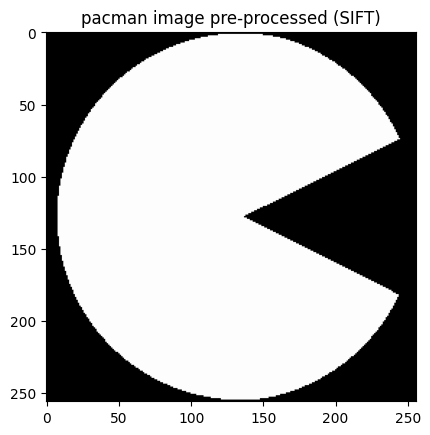

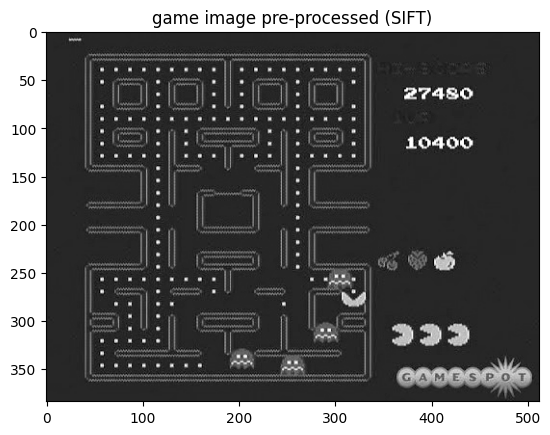

In [5]:
# load template image and test image
pacman_img = cv2.imread("pacman.png")
game_img = cv2.imread("game.jpg")

# preprocessing
pacman_img = convert_to_grayscale(pacman_img)
pacman_img = cv2.convertScaleAbs(pacman_img, alpha=1.3, beta=0)
game_img = convert_to_grayscale(game_img)
game_img = cv2.convertScaleAbs(game_img, alpha=1.3, beta=0)

# no mask is needed for both images
sift = cv2.SIFT_create()
pacman_kp_list, pacman_ds_list = sift.detectAndCompute(pacman_img, None)
game_kp_list, game_ds_list = sift.detectAndCompute(game_img, None)

# now we can use our descriptors and keypoints to match
# our "fingerprint" of pacman to the game image
# crossCheck makes our matcher stricter, requiring matches from both sides
# Im assuming the euclidean distance as it works reliably for many applications
bf_matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf_matcher.match(pacman_ds_list, game_ds_list)

print("BF matcher done")
pacman_rgb = cv2.cvtColor(pacman_img, cv2.COLOR_BGR2RGB)
game_rgb = cv2.cvtColor(game_img, cv2.COLOR_BGR2RGB)

plt.title("pacman image pre-processed (SIFT)")
plt.imshow(pacman_rgb)

plt.figure()
plt.title("game image pre-processed (SIFT)")
plt.imshow(game_rgb)

These matches don't really tell us if we found the source image properly. Time to draw where the matches were found
- we are concerned with distance, queryIdx, and trainIdx from the brute force matcher
- the ids tell us the indices from the template image and the game image that match in our descriptor array.
- The descriptor array is parallel, so we can also get keypoint data from the indices.

(430.3807678222656, 325.26513671875)
(420.4250183105469, 57.398799896240234)
(365.11865234375, 314.94219970703125)
(365.11865234375, 314.94219970703125)
(389.4110412597656, 308.68438720703125)


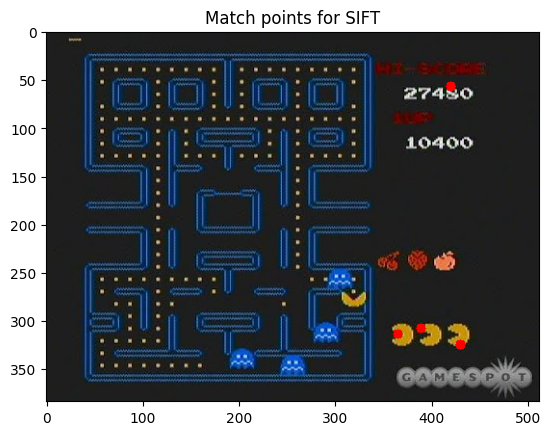

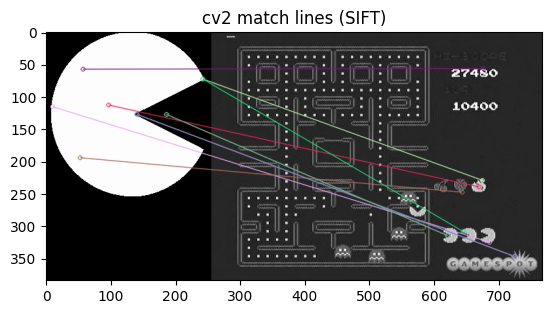

In [6]:
drawboard = cv2.imread("game.jpg")

distance_threshold = 335
for match in matches:
    pacman_kp = pacman_kp_list[match.queryIdx]
    game_kp = game_kp_list[match.trainIdx]

    # filter out bad points based on a distance threshold
    if(match.distance < distance_threshold):
        coord = game_kp.pt
        print(coord)
        cv2.circle(drawboard, (int(coord[0]), int(coord[1])), 5, (0, 0, 255), -1)

drawboard_rgb = cv2.cvtColor(drawboard, cv2.COLOR_BGR2RGB)
plt.title("Match points for SIFT")
plt.imshow(drawboard_rgb)

output_img = cv2.drawMatches(pacman_img, pacman_kp_list, game_img, game_kp_list, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure()
plt.title("cv2 match lines (SIFT)")
plt.imshow(output_img)

Our pre-processing and SIFT detector did a pretty good job, matching all instances of the pacman source image while only having 1 false positive. 
If necessary, we could improve this technique using Lowe's ratio test or edge detection to help highlight features.

Part 4: We will now be using ORB as the keypoint / feature detector.

Orb is such a huge pain to use. I need a whole pipeline to get things remotely working.

BF matcher done


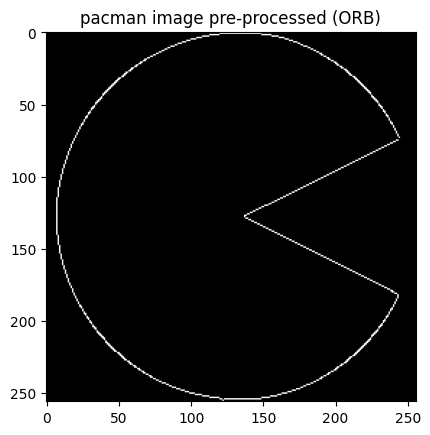

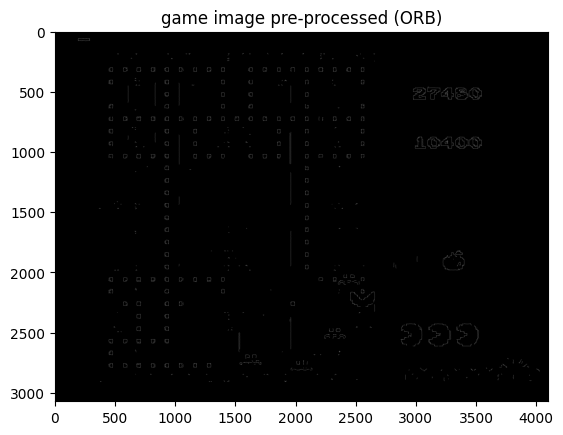

In [7]:
# the default keypoint quantity is really low for orb (500)
# we will need to increase this
orb_pacman = cv2.ORB_create(nfeatures=500)
orb_game = cv2.ORB_create(nfeatures=1000)

# orb is NOT scale invariant, so we should resize pacman to be more accurate to the screen
# it is rotation invariant
y_size = int(game_img.shape[0] * 8)
x_size = int(game_img.shape[1] * 8)
game_scaled = cv2.resize(game_img, (x_size, y_size), interpolation=cv2.INTER_NEAREST)

# we will add contrast to make it easier for ORB to see pacman
pacman_contrast = cv2.convertScaleAbs(pacman_img, alpha=1, beta=0.1)
game_contrast = cv2.convertScaleAbs(game_scaled, alpha=1, beta=1)

# orb works better if you do edge detection before processing
# Plus orb really wants textures to function, so we need absolutely
# EVERYTHING to make it do what we want
game_blurred = cv2.GaussianBlur(game_contrast, (7, 7), sigmaX=5)
pacman_edges = cv2.Canny(pacman_contrast, threshold1=100, threshold2=150)
game_edges = cv2.Canny(game_blurred, threshold1=100, threshold2=150)

# so ORB is weird. Its descriptors are binary, so 
# we will be using the hamming distance for our matcher
pacman_kp_list, pacman_ds_list = orb_pacman.detectAndCompute(pacman_edges, None)
game_kp_list, game_ds_list = orb_game.detectAndCompute(game_edges, None)

bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf_matcher.match(pacman_ds_list, game_ds_list)

print("BF matcher done")

plt.title("pacman image pre-processed (ORB)")
plt.imshow(pacman_edges, cmap="gray")

plt.figure()
plt.title("game image pre-processed (ORB)")
plt.imshow(game_edges, cmap="gray")

Dispalyin

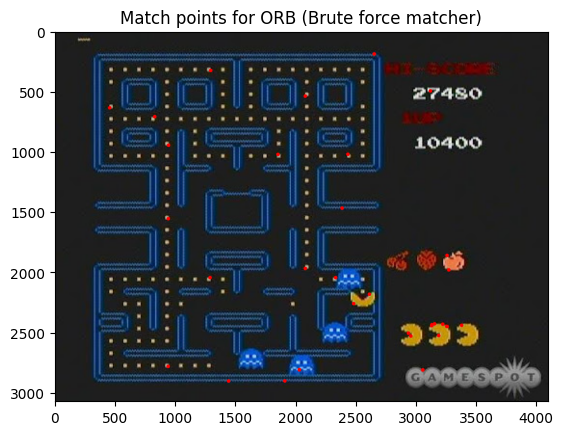

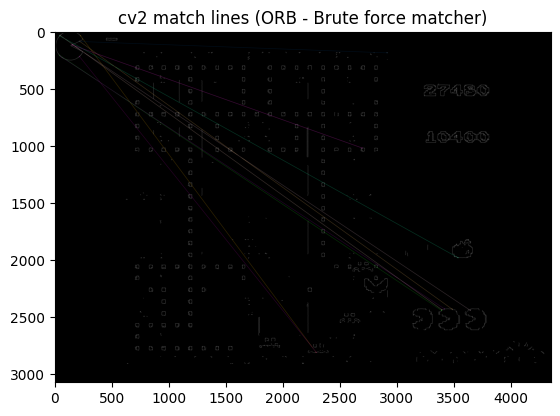

In [8]:
drawboard = cv2.imread("game.jpg")
drawboard = cv2.resize(drawboard, (x_size, y_size), interpolation=cv2.INTER_NEAREST)

distance_threshold = 50
for match in matches:
    pacman_kp = pacman_kp_list[match.queryIdx]
    game_kp = game_kp_list[match.trainIdx]

    # filter out bad points based on a distance threshold
    if(match.distance < distance_threshold):
        coord = game_kp.pt
        cv2.circle(drawboard, (int(coord[0]), int(coord[1])), 15, (0, 0, 255), -1)
drawboard_rgb = cv2.cvtColor(drawboard, cv2.COLOR_BGR2RGB)

plt.title("Match points for ORB (Brute force matcher)")
plt.imshow(drawboard_rgb)

output_img = cv2.drawMatches(pacman_edges, pacman_kp_list, game_edges, game_kp_list, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure()
plt.title("cv2 match lines (ORB - Brute force matcher)")
plt.imshow(output_img)

Orb is harder to use for pacman (albeit it is doable)
There are a few clear reasons for this.
- ORB is built to detect and match things that are textured and detailed. templates with edges, corners, and/or a complex shape is great for ORB.
- We are using pacman, which is almost just a circle, with no texture, and it only has 3 edges. Pacman is literally built to evade the ORB feature detector.
- We would need at least one more processing technique to detect pacman alone rather than just features related to pacman.

Using Orb on KNN:

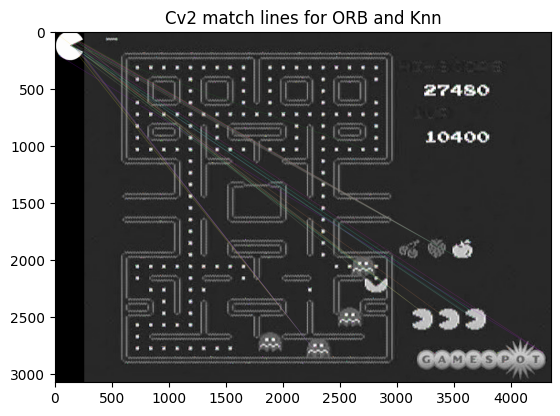

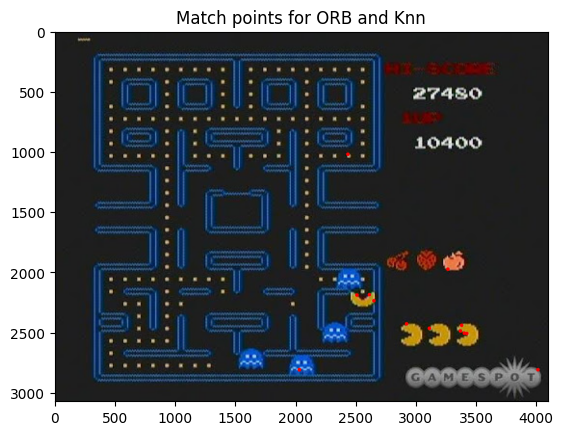

In [9]:
orb = cv2.ORB_create(nfeatures=5000)
pacman_kp_list, pacman_ds_list = orb.detectAndCompute(pacman_edges, None)
game_kp_list, game_ds_list = orb.detectAndCompute(game_edges, None)
bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
matches = bf_matcher.knnMatch(pacman_ds_list, game_ds_list, k=2)
drawboard = cv2.imread("game.jpg")
drawboard = cv2.resize(drawboard, (x_size, y_size), interpolation=cv2.INTER_NEAREST)

# apply Lowe's ratio test to filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.8 * n.distance:
        good_matches.append(m)
plt.title("Cv2 match lines for ORB and Knn")
output_img = cv2.drawMatches(pacman_contrast, pacman_kp_list, game_contrast, game_kp_list, good_matches[:30], None)
plt.imshow(output_img)

for match in good_matches:
    pacman_kp = pacman_kp_list[match.queryIdx]
    game_kp = game_kp_list[match.trainIdx]
    coord = game_kp.pt
    cv2.circle(drawboard, (int(coord[0]), int(coord[1])), 15, (0, 0, 255), -1)
    
drawboard_rgb = cv2.cvtColor(drawboard, cv2.COLOR_BGR2RGB)

plt.figure()
plt.title("Match points for ORB and Knn")
plt.imshow(drawboard_rgb)

Applying K nearest neighbors, Lowe's Ratio Test, and our pre-processing techniques gives us much more accurate results than with brute force matching and pre-processing alone. We only have two rogue points here, even though ORB is bad at finding circular objects.

Last but not least, we will be using FLANN. FLANN is a sped up version of Knn, so I expect either the same performance or worse.

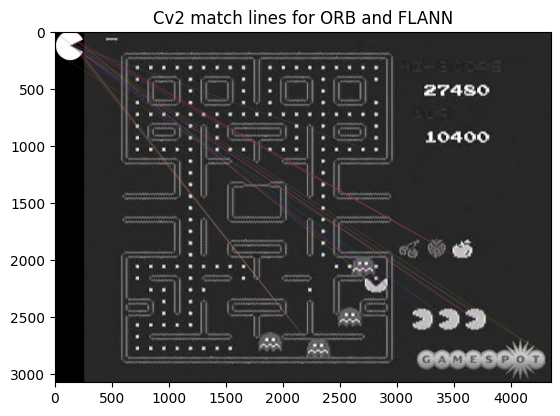

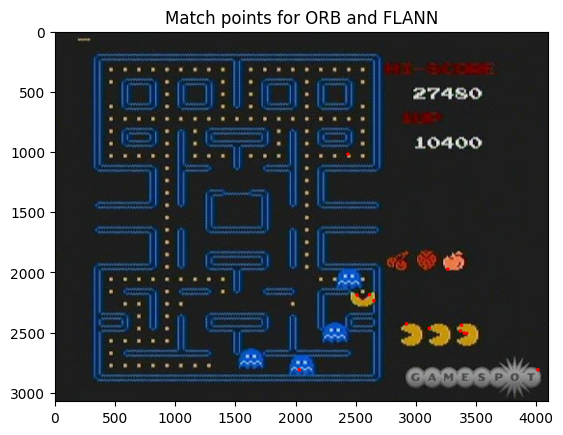

In [11]:
index_params = dict(algorithm=6, # LSH. Good for ORB.
                    table_number=6,  
                    key_size=12,     
                    multi_probe_level=1)  # might as well go fast since its FLANN

search_params = dict(checks=50)  # Higher means more accurate results
flann_matcher = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann_matcher.knnMatch(pacman_ds_list, game_ds_list, k=2)  # k=2 for ratio test

# apply Lowe's ratio test to filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.8 * n.distance:
        good_matches.append(m)
plt.title("Cv2 match lines for ORB and FLANN")
output_img = cv2.drawMatches(pacman_contrast, pacman_kp_list, game_contrast, game_kp_list, good_matches[:30], None)
plt.imshow(output_img)

for match in good_matches:
    pacman_kp = pacman_kp_list[match.queryIdx]
    game_kp = game_kp_list[match.trainIdx]
    coord = game_kp.pt
    cv2.circle(drawboard, (int(coord[0]), int(coord[1])), 15, (0, 0, 255), -1)
    
drawboard_rgb = cv2.cvtColor(drawboard, cv2.COLOR_BGR2RGB)

plt.figure()
plt.title("Match points for ORB and FLANN")
plt.imshow(drawboard_rgb)

We got a nice case of FLANN performing just as well as Knn, while also being faster. After working in this project I would certainly prefer using SIFT unless speed is important, because ORB can have some demanding requirements. However, there is also the case where we could be detecting a less "smooth' object with edges and texture. ORB is good at detecting those, making it much more viable in that case. Then there is the question of scale invariance, which SIFT (and SURF) can provide while ORB can't. Both algorithms provide angle invariance though.